# Project 1 Part 1

Begin, as always, by importing the required python packages to complete the claculations and analysis

In [1]:
import pandas as pd                     # Required for reading the .csv from NEA
import astropy                          # Useful package for working with astronomy specific units and constants
from astropy import units as u                # Submodule of astropy
from astropy import constants as c            #
import numpy as np                      # Useful mathematical functions
import matplotlib.pyplot as plt         # Required for plotting data

With everything imported and assuming the .csv file is traceable from this kernel, we can read in the data

In [2]:
PData = pd.read_csv("PS_2023.01.26_13.12.40.csv", skiprows=100) 
    # Skipping 100 rows in order to ensure that pandas is not confused by the commenting

# By uncommenting the below code, we can match the first and last row to the data seen on the NEA website to ensure the
# dataframe is complete. We can also compare the length of the dataframe to the number of planets reported by NEA (expected
# 5243 planets)

#print("First row data:\n", PData.head(1), "\nLast row data:\n", PData.tail(1), "\nNumber of Planets:", len(PData))

Assuming you have uncommented the code, we can in fact match up the first and last row, as well as verify the number of rows is equal to the number of planets. Before we move onto the analysis, let's manually create a dataframe for the solar system data.

In [3]:
pl_name = ["Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"]         # Various information regarding our solar system planets
pl_orbper = [87.9691,224.701,365.256363004,686.980,4332.59,10759.22,30688.5,60195]
pl_orbsmax = [0.387098,0.723332,1,1.52368055,5.2038,9.5826,19.19126,30.07]
pl_rade = [0.3829,0.9499,1,0.532,10.973,9.1402,3.9763962,3.8603749]
pl_bmasse = [0.055,0.815,1,0.107,317.8,95.159,14.536,17.147]
color = ['#990000','#bf7300','#c7d100','#69d900','#45ffd7','#0077d9','#9249e6','#ff1fbc']

SolarData = pd.DataFrame({"pl_name":pl_name, "pl_orbper":pl_orbper, "pl_orbsmax":pl_orbsmax, 
                          "pl_rade":pl_rade, "pl_bmasse":pl_bmasse, "color":color})

Let's also split our NEA data into separate dataframes based on the discovery method, since this project focuses on the specific detection methods and their limitations -- this is to say, it would be useful to know where planets discovered with a certain method lay in the data so we can determine if our limitation lines make sense.

In [4]:
PDataTransit = PData.drop(PData[PData.discoverymethod != "Transit"].index)                     # These 5 are the important ones for this project
PDataImaging = PData.drop(PData[PData.discoverymethod != "Imaging"].index)
PDataRV = PData.drop(PData[PData.discoverymethod != "Radial Velocity"].index)
PDataMicro = PData.drop(PData[PData.discoverymethod != "Microlensing"].index)
PDataAstro = PData.drop(PData[PData.discoverymethod != "Astrometry"].index)

PDataDK = PData.drop(PData[PData.discoverymethod != "Disk Kinematics"].index)                  # These 6 remaining methods are not within the scope of this project
PDataETV = PData.drop(PData[PData.discoverymethod != "Eclipse Timing Variations"].index)
PDataOBM = PData.drop(PData[PData.discoverymethod != "Orbital Brightness Modulation"].index)
PDataPT = PData.drop(PData[PData.discoverymethod != "Pulsar Timing"].index)
PDataPTV = PData.drop(PData[PData.discoverymethod != "Pulsation Timing Variations"].index)
PDataTTV = PData.drop(PData[PData.discoverymethod != "Transit Timing Variations"].index)

PDataEx = pd.concat([PDataDK,PDataETV,PDataOBM,PDataPT,PDataPTV,PDataTTV])

#len(PDataTransit)+len(PDataImaging)+len(PDataRV)+len(PDataMicro)+len(PDataAstro)+len(PDataEx)  # Used to check if 5243 planets are still recognized

Let's move into the data analysis. First, we will start by defining graph parameters for the rest of the notebook.

In [5]:
# Create a dictionary with updated parameters for
# the default matplotlib style.

style_revisions = {
 'axes.linewidth':  1.5, 
 'xtick.top' : True,         
 'ytick.right' :  True,
 'xtick.direction' : 'in',    
 'ytick.direction' : 'in', 
 'xtick.major.size' : 11,     
 'ytick.major.size' : 11,
 'xtick.minor.size' : 5.5,    
 'ytick.minor.size' : 5.5,      
 'font.size' : 16,              
 'figure.figsize' : [13.125, 8.3125], 
 'lines.linewidth' : 2.      
}

# Update the matplotlib dictionary.
plt.rcParams.update(style_revisions)

With this dictionary, we can now move into the actual data analysis. We start with determining the relationship Planet Mass vs. Orbital Period as well as the Radial Velocity detection limit. Let's first take a look at the detection limits.

## Radial Velocity Technique
For the Radial Velocity detection we have the expression
$$
K = \frac{M_p}{M_{\odot}} \sqrt{\frac{G M_{\odot}}{a_p}}
$$
We can rearrange for $M_p$ to find an equation for the detection limit for the radial velocity method -- namely,
$$
M_p = KM_{\odot} \sqrt{\frac{a_p}{G M_{\odot}}}
$$
However, we need this in terms of an orbital period. Luckily, we can utilize Kepler's Third Law to find $a_p$ in terms of $T$ (measured in seconds). So,
$$
T^2 = \left(\frac{4\pi^2}{GM_{\odot}}\right)a_{p}^3
$$
Translates to,
$$
a_{p} = \left(\frac{T^2 G M_{\odot}}{4\pi^2}\right)^{\frac{1}{3}}
$$
Using this, we can finally express $M_p$ as a function of time,
$$
M_p = KM_{\odot} \sqrt{\frac{\left(\frac{T^2 G M_{\odot}}{4\pi^2}\right)^{\frac{1}{3}}}{G M_{\odot}}}
$$
## Direct Imaging Technique
Now, moving onto Direct Imaging, we have the equation
$$
f = f_{ref} + f_{em}
$$
Which expands into
$$
f = \left(\frac{R_{p}}{R_{*}}^2\right)\left[\frac{1}{4}\left(1/a/R_{*}\right)^2 + \frac{exp\left[\frac{hc}{\lambda k_{B} T_{*}}\right]-1}{exp\left[\frac{hc}{\lambda k_{B} T_{p}}\right]-1}\right]
$$
The $\frac{1}{4}\left(1/a/R_{*}\right)^2$ is ignored as it is dominated by $\frac{exp\left[\frac{hc}{\lambda k_{B} T_{*}}\right]-1}{exp\left[\frac{hc}{\lambda k_{B} T_{p}}\right]-1}$
Giving us,
$$
f = \left(\frac{R_{p}}{R_{*}}\right)^2\left[\frac{exp\left[\frac{hc}{\lambda k_{B} T_{*}}\right]-1}{exp\left[\frac{hc}{\lambda k_{B} T_{p}}\right]-1}\right]
$$
If we assume an $f$ of $10^{-7}$, star temperature $T_{\odot}$, planet temperature $T_{p} = 130 K$, $\lambda$ of $11 \mu m$, and then solve for $R_p$, we find
$$
R_{p} = 10.451 R_{⊕}
$$
Note: The wavelength was chosen as it should lie somewhere between the maximum emission of a solar body and Jupiter-like exoplanet. We also have a secondary limitation as part of this technique, which is the resolvability from the host star. We use the following equation,
$$
\theta = 1.22 \frac{\lambda}{D}
$$
We use $\lambda = 22.3 \mu m$ and $D= 8 m$ to find,
$$
\theta = 3.4*10^{-6} rads
$$
Which we can convert to arcseconds, and we find $\theta = 0.7 arcsec$. So, for two objects to be resolvable, they MUST be separated by 0.7 arcseconds from our view. So, we just assume that the minimum orbital distance detected through direct imaging is the secondary limit. In all honesty, there is no good way to go about determining this two dimensionally since the distance the star/exoplanet pair are away from us is not considered, which would be the only way to determine a boundary for what is possible to detect.

In [6]:
my_min = PDataImaging['pl_orbsmax'].loc[PDataImaging['pl_orbsmax'].idxmin()]      # Minimum in column 'pl_orbsmax'
print(my_min, "AU")

2.6 AU


So, our best case scenario is detecting an exoplanet >2.6 AU from its host star with a radius > 10.451 $R_{⊕}$. Converting these to Mass and Orbital Periods is simple.
$$
T = \frac{\sqrt{\frac{4 \pi^2 a_{p}^3}{GM_{\odot}}}}{60*60*24}
$$
If we plug in values, we find $T = 1531.369$ Days, which is the minimum orbital period that exoplanets are detectable at. Doing the same thing for the Radius, and converting it to Mass using the Jovian world relationship, we have,
$$
\frac{R}{R_{⊕}} = \left(\frac{M}{M_{⊕}}\right)^{-0.04}
$$
If we use Jupiter as an example, and plug in values that correspond to each planet, we find the following
$$
C * \frac{R}{R_{⊕}} = \left(\frac{M}{M_{⊕}}\right)^{-0.04} \rightarrow C * 10.961 = 0.794
$$
Our constant is then found to be 0.0724, and we can finally rearrange for the final answer, assuming a Jovian world
$$
(10.451 * 0.0724)^{\frac{-1}{0.04}} = 1054.56
$$
This answer is in units $M_{⊕}$
## Transit Photometry Technique
The key to Transit Photometry is the following equation,
$$
SNR = \frac{\delta}{\sigma_{CDPP}}\sqrt{\frac{n_{tr}t_{dur}}{3 hr}}
$$
Now, we use the following equalities,
$$n_{tr} = \frac{90d}{P}$$
$$\delta = \frac{R_{p}^2}{R_{\odot}^2}$$
$$t_{dur} = 3.91 hr \left(\frac{P}{10 d}\right)^{\frac{1}{3}}$$
Now, we can solve for the planet radius, and we find
$$R_{p} = a \left(\frac{P}{d}\right)^{\frac{1}{6}}$$
Now, we know the mass-radius relationships, which will be worked with below,
$$\frac{R_{p}}{R_{⊕}} \approx \left(\frac{M_{p}}{M_{⊕}}\right)^{0.28}$$
Rearrange for $\frac{M}{M_{⊕}}$
$$\frac{M}{M_{⊕}} = \left(\frac{R_{p}}{R_{⊕}}\right)^{3.5714}$$
Is the relationship for planetary bodies up until $2M_{⊕}$. So, we now make this substitution in the equation.
$$\frac{M}{M_{⊕}} = \left(a \left(\frac{P}{d}\right)^{\frac{1}{6}}\right)^{3.5714}$$
If we graph this equation, we can locate the orbital period in days at which the mass equates to $2M_{⊕}$. This happens to be at 344.705 days, which is the domain limit of the first piecewise function. Now, we will move on to the second piecewise function, which has the same exact structure with a different exponent, it is shown below.
$$\frac{M}{M_{⊕}} = \left(a \left(\frac{P}{d}\right)^{\frac{1}{6}}\right)^{1.6949}$$


<function matplotlib.pyplot.show(close=None, block=None)>

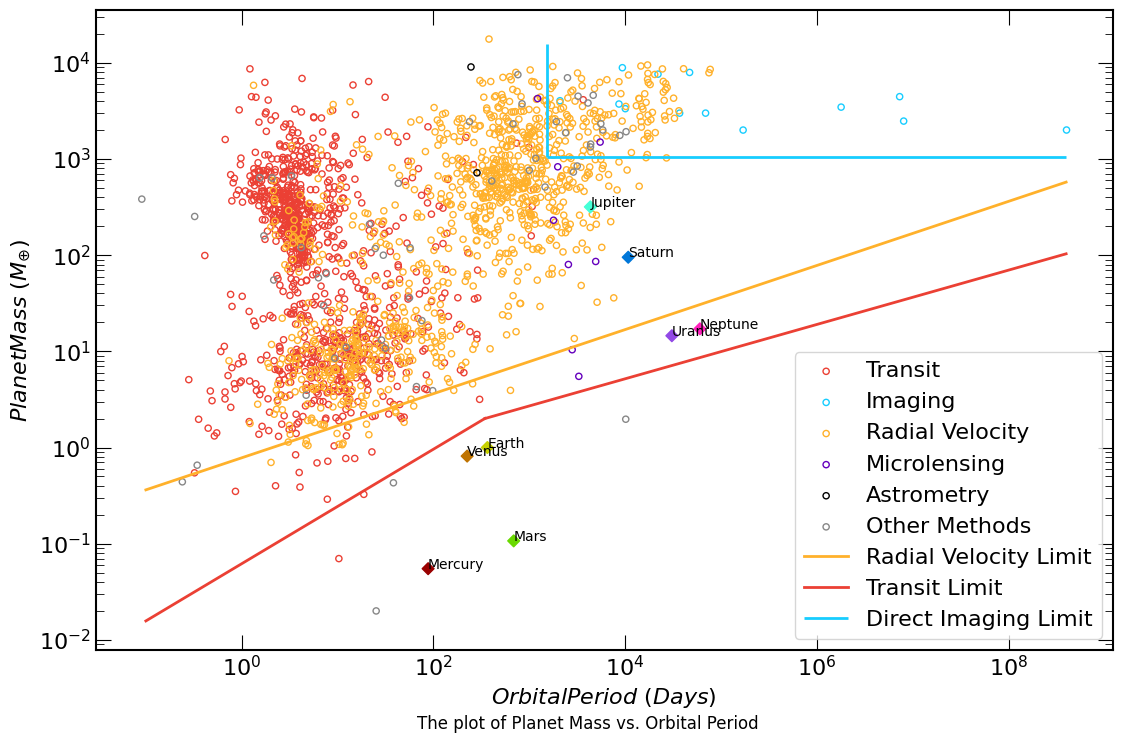

In [44]:
plt.scatter(x = PDataTransit.pl_orbper, y = PDataTransit.pl_bmasse, s=20, facecolors='none', edgecolors='#eb4034', label="Transit")
plt.scatter(x = PDataImaging.pl_orbper, y = PDataImaging.pl_bmasse, s=20, facecolors='none', edgecolors='#17cdff', label="Imaging")
plt.scatter(x = PDataRV.pl_orbper, y = PDataRV.pl_bmasse, s=20, facecolors='none', edgecolors='#ffb12b', label="Radial Velocity")
plt.scatter(x = PDataMicro.pl_orbper, y = PDataMicro.pl_bmasse, s=20, facecolors='none', edgecolors='#6500bd', label="Microlensing")
plt.scatter(x = PDataAstro.pl_orbper, y = PDataAstro.pl_bmasse, s=20, facecolors='none', edgecolors='#000000', label="Astrometry")
plt.scatter(x = PDataEx.pl_orbper, y = PDataEx.pl_bmasse, s=20, facecolors='none', edgecolors='#878787', label="Other Methods")
plt.scatter(x = SolarData["pl_orbper"], y = SolarData["pl_bmasse"], c = SolarData["color"], marker = 'D')
                                                                 # Create a plot with the planet mass on the y-axis and orbital period on the x-axis
# Begin Radial Velocity Limit Plotting
K = 0.5                                                          # Radial Velocity Amplitude signal in m/s (WYIN NEID Instrument)
x = np.linspace(0.1,10**8.6,1000)                                # Domain of Orbital Period in Days
y0 = K * c.M_sun * np.sqrt(((((x*86400)**2) * c.G * c.M_sun) / (4 * np.pi**2))**(1/3) / (c.G * c.M_sun))   # Function of mass (kg) vs orbital period (days)
y = y0 / c.M_earth                                               # Conversion to mass (M_earth) vs orbital period (days)
plt.plot(x, y, '#ffb12b', label="Radial Velocity Limit")

# Begin Transit limit Plotting
x = np.linspace(0.1,344.705,1000)
y0 = (0.623 * c.R_earth * (x) ** (1 / 6)) ** 3.5714
y = y0 / c.M_earth
plt.plot(x, y, '#eb4034', label="Transit Limit")
x = np.linspace(344.705,10**8.6,1000)
y0 = 15000000000000 * (0.623 * c.R_earth * (x) ** (1 / 6)) ** 1.6949
y = y0 / c.M_earth
plt.plot(x, y, '#eb4034')

# Begin Direct Imaging Limit Plotting
xs = [10**(-1), 10**4.2]
ys = [0.1,10**8.6]
plt.vlines(x = 1531.369, ymin = 1054.56, ymax = max(xs), colors = '#17cdff', label = "Direct Imaging Limit")
plt.hlines(y = 1054.56, xmin = 1531.369, xmax = max(ys), colors = '#17cdff')

plt.legend(loc='lower right')

texts = [plt.annotate(SolarData.pl_name[i], (SolarData.pl_orbper[i], SolarData.pl_bmasse[i]), fontsize=10) for i in range(len(SolarData.pl_orbper))]
    
plt.xlabel('$Orbital Period$ ($Days$)')                               # Create a plot label for the x-axis
plt.ylabel('$Planet Mass$ ($M_{⊕}$)')                                # Create a plot label for the y-axis
plt.figtext(0.5, 0.015,"The plot of Planet Mass vs. Orbital Period",       # Create plot caption
                     wrap=True,horizontalalignment='center', fontsize=12)
plt.yscale('log')                                                          # Change y-scale to log
plt.xscale('log')                                                          # Change x-scale to log

plt.show                                                               # Output the plot

## Radial Velocity Technique
Now, do the same for the Planet Mass vs. Semi-Major Axis.
As we saw before with the radial velocity method
$$
M_p = KM_{\odot} \sqrt{\frac{a_p}{G M_{\odot}}}
$$
This is already in simplest form, so we need not mess around with the equation more.
## Direct Imaging Technique
As we found in the preparation for the first graph, the mass limit is $1054.56 M_{⊕}$. The Semi-Major Axis limit was also known from the collected data to be $2.6$ AU. No further work is required for this section
## Transit Photometry Technique
Like before, we use the given equation, however, this time, we will have to convert the Orbital period into a semimajor axis using,
$$T = \sqrt{\frac{4\pi^{2} a_{p}^{3}}{GM_{\odot}}}$$
This will be done below,
$$\frac{M}{M_{⊕}} = \left(a \left(\sqrt{\frac{4\pi^{2} a_{p}^{3}}{{GM_{\odot}}}} * \frac{1}{d}\right)^{\frac{1}{6}}\right)^{3.5714}$$
$$$$

<function matplotlib.pyplot.show(close=None, block=None)>

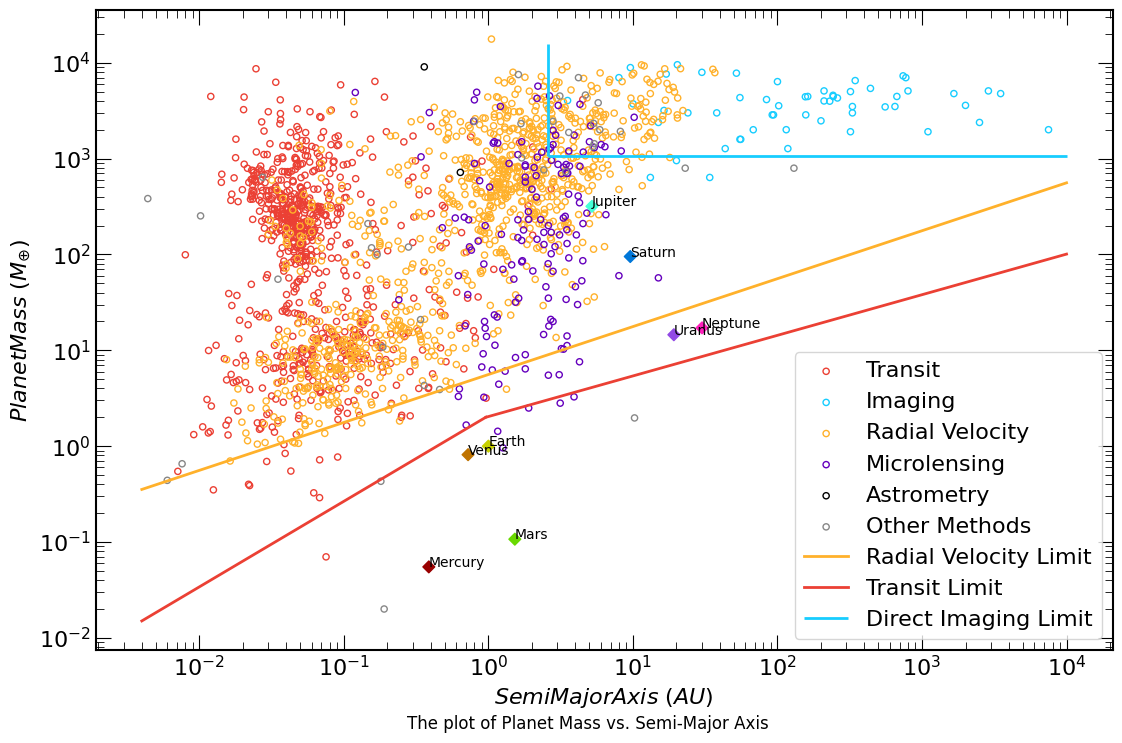

In [45]:
plt.scatter(x = PDataTransit.pl_orbsmax, y = PDataTransit.pl_bmasse, s=20, facecolors='none', edgecolors='#eb4034', label="Transit")
plt.scatter(x = PDataImaging.pl_orbsmax, y = PDataImaging.pl_bmasse, s=20, facecolors='none', edgecolors='#17cdff', label="Imaging")
plt.scatter(x = PDataRV.pl_orbsmax, y = PDataRV.pl_bmasse, s=20, facecolors='none', edgecolors='#ffb12b', label="Radial Velocity")
plt.scatter(x = PDataMicro.pl_orbsmax, y = PDataMicro.pl_bmasse, s=20, facecolors='none', edgecolors='#6500bd', label="Microlensing")
plt.scatter(x = PDataAstro.pl_orbsmax, y = PDataAstro.pl_bmasse, s=20, facecolors='none', edgecolors='#000000', label="Astrometry")
plt.scatter(x = PDataEx.pl_orbsmax, y = PDataEx.pl_bmasse, s=20, facecolors='none', edgecolors='#878787', label="Other Methods")
plt.scatter(x = SolarData["pl_orbsmax"], y = SolarData["pl_bmasse"], c = SolarData["color"], marker = 'D')
                                            # Create a plot with the planet mass on the y-axis and semi-major axis on the x-axis
# Begin Radial Velocity Limit Plotting
K = 0.5                                                        # Radial Velocity Amplitude signal in m/s (WYIN NEID Instrument)
x = np.linspace(0.004,10000,1000)                              # Domain of Semi-Major Axis in AU
y0 = K * c.M_sun * np.sqrt((x * 1.496e11) / (c.G * c.M_sun))   # Function of mass (kg) vs semi-major axis (AU)
y = y0 / c.M_earth                                             # Conversion to mass (M_earth) vs semi-major axis (AU)
plt.plot(x, y, '#ffb12b', label = "Radial Velocity Limit")

# Begin Transit limit Plotting
x = np.linspace(0.004,0.962,1000)
y0 = (0.623 * c.R_earth * (np.sqrt((4 * (np.pi ** 2) * ((x * 1.496e11) ** 3)) / (c.G * c.M_sun)) * (1 / 86400)) ** (1 / 6)) ** 3.5714
y = y0 / c.M_earth
plt.plot(x, y, '#eb4034', label="Transit Limit")
x = np.linspace(0.962,10000,1000)
y0 = 15000000000000 * (0.623 * c.R_earth * (np.sqrt((4 * (np.pi ** 2) * ((x * 1.496e11) ** 3)) / (c.G * c.M_sun)) * (1 / 86400)) ** (1 / 6)) ** 1.6949
y = y0 / c.M_earth
plt.plot(x, y, '#eb4034')

# Begin Direct Imaging Limit Plotting
xs = [10**(-1), 10**4.2]
ys = [0.004,10000]
plt.vlines(x = 2.6, ymin = 1054.56, ymax = max(xs), colors = '#17cdff', label = "Direct Imaging Limit")
plt.hlines(y = 1054.56, xmin = 2.6, xmax = max(ys), colors = '#17cdff')

plt.legend(loc='lower right')

texts = [plt.annotate(SolarData.pl_name[i], (SolarData.pl_orbsmax[i], SolarData.pl_bmasse[i]), fontsize=10) for i in range(len(SolarData.pl_orbper))]
    
plt.xlabel('$SemiMajor Axis$ ($AU$)')                                # Create a plot label for the x-axis
plt.ylabel('$Planet Mass$ ($M_{⊕}$)')                                # Create a plot label for the y-axis
plt.figtext(0.5, 0.015,"The plot of Planet Mass vs. Semi-Major Axis",      # Create plot caption
                     wrap=True,horizontalalignment='center', fontsize=12)
plt.yscale('log')                                                          # Change y-scale to log
plt.xscale('log')                                                          # Change x-scale to log
plt.show                                                                   # Output the plot

For Radius vs. Period with the transit method.

## Radial Velocity Technique
To complete the Radial Velocity method, we must utilize the Mass-Radius relationships from the slides. There are 4, so our result will be piecewise.

For the first branch, we have,
$$
\frac{R_{1}}{R_{⊕}} \approx \left(\frac{M}{M_⊕}\right)^{0.28}
$$
Giving us
$$
R_{1} = R_{⊕} \left(\frac{M}{M_⊕}\right)^{0.28}
$$
Now, we can simply insert our equation for M as a function of T to get back an equation that varies with T and produces a Planet Radius.
$$
R_{1} = R_{⊕} \left(\frac{KM_{\odot} \sqrt{\frac{\left(\frac{T^2 G M_{\odot}}{4\pi^2}\right)^{\frac{1}{3}}}{G M_{\odot}}}}{M_⊕}\right)^{0.28}
$$
For the next branch, we must consider the value $R_{1}$ when $M = 2M_{⊕}$. This is easy enough to calculate, it is $R_{1} = 1.214 R_{⊕}$. So,
$$
\frac{R_{2}}{R_{⊕}} \approx \left(\frac{M}{M_{⊕}}\right)^{0.59}
$$
Now, $R_{2} = R_{1}$ when $M = 2M_{⊕}$. So,
$$
C * R_{2} = R_{⊕} * (2)^{0.59} \rightarrow C * R_{2} = 1.505R_{⊕}
$$
So, find C such that $R_{2}$ is equal to $1.214R_{⊕}$ again. $C = 1.240$. Again, plugging everything back into the big equation, we find that the second constant is $C = 0.0576$ and thus have the set of equations to produce the full limit plot for the bounds of the data. We do not need to do this for the final mass relationship.
## Direct Imaging Technique
Once again, we borrow work from the first graph and realize that the Orbital Period limit is known to be $2.6$ AU and the Planet Radius is $10.451R_{⊕}$. No further work must be done to plot these values.
## Transit Photometry Technique

<function matplotlib.pyplot.show(close=None, block=None)>

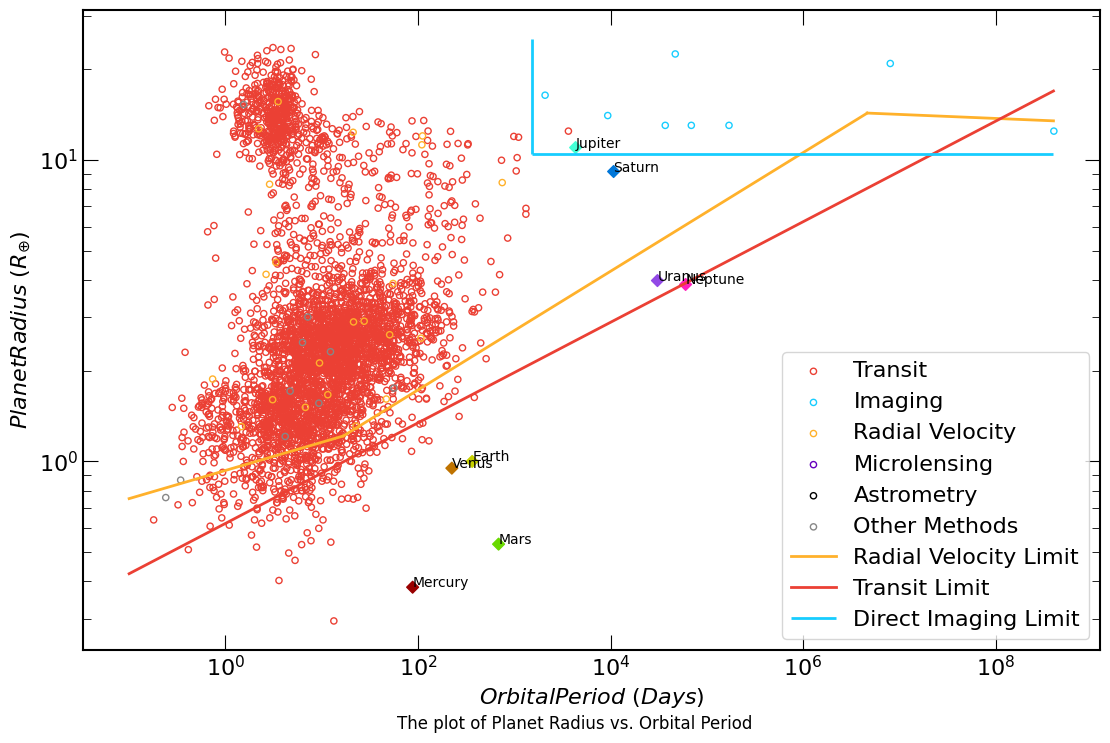

In [9]:
plt.scatter(x = PDataTransit.pl_orbper, y = PDataTransit.pl_rade, s=20, facecolors='none', edgecolors='#eb4034', label="Transit")
plt.scatter(x = PDataImaging.pl_orbper, y = PDataImaging.pl_rade, s=20, facecolors='none', edgecolors='#17cdff', label="Imaging")
plt.scatter(x = PDataRV.pl_orbper, y = PDataRV.pl_rade, s=20, facecolors='none', edgecolors='#ffb12b', label="Radial Velocity")
plt.scatter(x = PDataMicro.pl_orbper, y = PDataMicro.pl_rade, s=20, facecolors='none', edgecolors='#6500bd', label="Microlensing")
plt.scatter(x = PDataAstro.pl_orbper, y = PDataAstro.pl_rade, s=20, facecolors='none', edgecolors='#000000', label="Astrometry")
plt.scatter(x = PDataEx.pl_orbper, y = PDataEx.pl_rade, s=20, facecolors='none', edgecolors='#878787', label="Other Methods")
plt.scatter(x = SolarData["pl_orbper"], y = SolarData["pl_rade"], c = SolarData["color"], marker = 'D')
                                            # Create a plot with the planet mass on the y-axis and semi-major axis on the x-axis
# Begin Radial Velocity Limit Plotting
K = 0.5                                                        # Radial Velocity Amplitude signal in m/s (WYIN NEID Instrument)
x = np.linspace(0.1,16.723,1000)                               # Domain of Orbital Period in Days
y0 = ((K * c.M_sun * np.sqrt((((((x * 86400)) ** 2) * c.G * c.M_sun) / (4 * (np.pi ** 2))) ** (1 /3) / (c.G * c.M_sun))) / (c.M_earth)) ** 0.28   # Function of radius (m) vs orbital period (Days)
y = y0                                                         # Conversion to radius (R_earth) vs orbital period (days)
plt.plot(x, y, '#ffb12b', label = "Radial Velocity Limit")
x = np.linspace(16.723,4.629 * 10 ** 6,1000)                             
y0 = (1 / 1.2397) * ((K * c.M_sun * np.sqrt((((((x * 86400)) ** 2) * c.G * c.M_sun) / (4 * np.pi ** 2)) ** (1 /3) / (c.G * c.M_sun))) / (c.M_earth)) ** 0.59 
y = y0                                          
plt.plot(x, y, '#ffb12b')
x = np.linspace(4.629 * 10 ** 6,10 ** 8.6,1000)                            
y0 = 17.35 * ((K * c.M_sun * np.sqrt((((((x * 86400)) ** 2) * c.G * c.M_sun) / (4 * np.pi ** 2)) ** (1 /3) / (c.G * c.M_sun))) / (c.M_earth)) ** (-0.04)
y = y0                                         
plt.plot(x, y, '#ffb12b')
    
# Begin Transit limit Plotting                                               
x = np.linspace(0.1,10**8.6,1000) * u.d            # Domain of Orbital Period in Days
y0 = (0.623*u.R_earth) * (x / u.d)**(1/6)          # Function of radius (kg) vs orbital period (days)
y = y0                                             # Conversion to radius (R_earth) vs orbital period (days)
plt.plot(x, y, '#eb4034', label="Transit Limit")

# Begin Direct Imaging Limit Plotting
xs = [10**(-1), 10**1.4]
ys = [0.1, 10**8.6]
plt.vlines(x = 1531.369, ymin = 10.451, ymax = max(xs), colors = '#17cdff', label = "Direct Imaging Limit")
plt.hlines(y = 10.451, xmin = 1531.369, xmax = max(ys), colors = '#17cdff')

plt.legend(loc='lower right')

texts = [plt.annotate(SolarData.pl_name[i], (SolarData.pl_orbper[i], SolarData.pl_rade[i]), fontsize=10, ha='left') for i in range(len(SolarData.pl_orbper))]

plt.xlabel('$Orbital Period$ ($Days$)')                               # Create a plot label for the x-axis
plt.ylabel('$Planet Radius$ ($R_{⊕}$)')                              # Create a plot label for the y-axis
plt.figtext(0.5, 0.015,"The plot of Planet Radius vs. Orbital Period",     # Create plot caption
                     wrap=True,horizontalalignment='center', fontsize=12)
plt.yscale('log')                                                          # Change y-scale to log
plt.xscale('log')                                                          # Change x-scale to log
plt.show                                                                   # Output the plot

## Radial Velocity Technique
Simply repeat the scales found in the previous section, now using the Semi-Major Axis dependent version of the equation. Notice that the fourth section of masses (> 0.08 $M_{\odot}$) is also not present within the bounds of the graph.
## Direct Imaging Technique
Unsurprisingly, we are again borrowing from the work of the first section, there is no more work to be done for preparing this limit plot.
## Transit Photometry Technique

<function matplotlib.pyplot.show(close=None, block=None)>

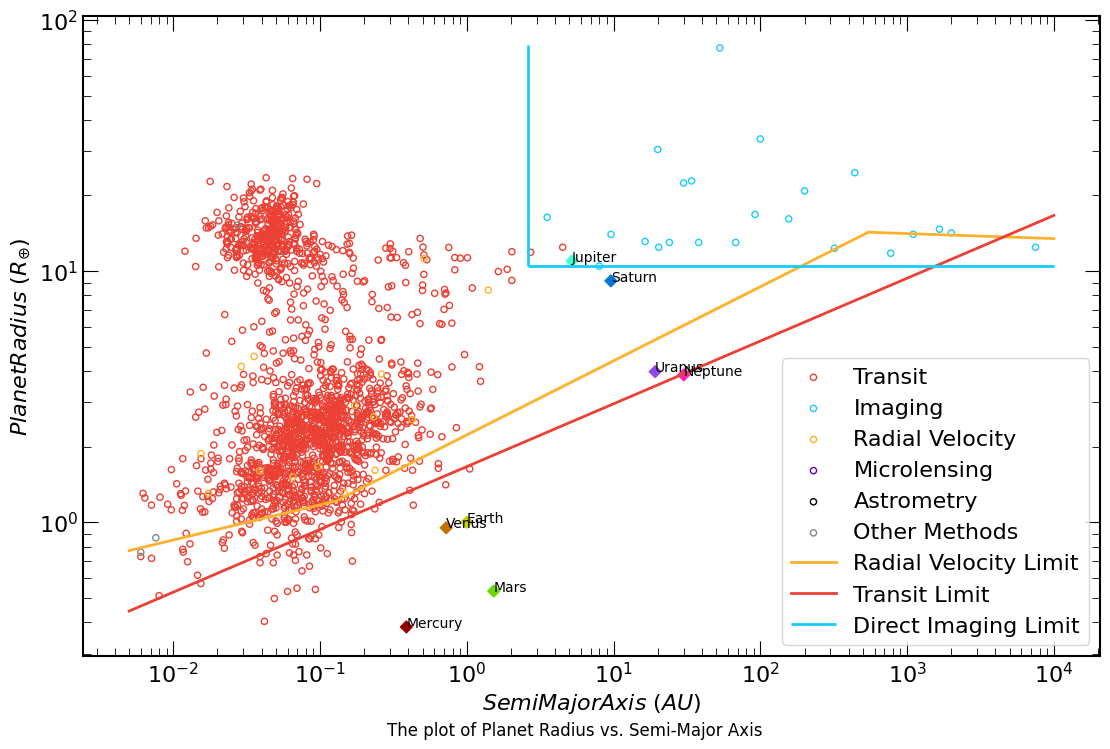

In [10]:
plt.scatter(x = PDataTransit.pl_orbsmax, y = PDataTransit.pl_rade, s=20, facecolors='none', edgecolors='#eb4034', label="Transit")
plt.scatter(x = PDataImaging.pl_orbsmax, y = PDataImaging.pl_rade, s=20, facecolors='none', edgecolors='#17cdff', label="Imaging")
plt.scatter(x = PDataRV.pl_orbsmax, y = PDataRV.pl_rade, s=20, facecolors='none', edgecolors='#ffb12b', label="Radial Velocity")
plt.scatter(x = PDataMicro.pl_orbsmax, y = PDataMicro.pl_rade, s=20, facecolors='none', edgecolors='#6500bd', label="Microlensing")
plt.scatter(x = PDataAstro.pl_orbsmax, y = PDataAstro.pl_rade, s=20, facecolors='none', edgecolors='#000000', label="Astrometry")
plt.scatter(x = PDataEx.pl_orbsmax, y = PDataEx.pl_rade, s=20, facecolors='none', edgecolors='#878787', label="Other Methods")
plt.scatter(x = SolarData["pl_orbsmax"], y = SolarData["pl_rade"], c = SolarData["color"], marker = 'D')
                                            # Create a plot with the planet mass on the y-axis and semi-major axis on the x-axis
# Begin Radial Velocity Limit Plotting
K = 0.5                                                       # Radial Velocity Amplitude signal in m/s (WYIN NEID Instrument)
x = np.linspace(0.005,0.128,100)                              # Domain of Semi-Major Axis in AU
y0 = c.R_earth * ((K * c.M_sun * np.sqrt((x * 1.496*(10**11)) / (c.G * c.M_sun))) / (c.M_earth)) ** 0.28   # Function of radius (R_earth) vs semi-major axis (AU)
y = y0 / c.R_earth                                            # Conversion to radius (R_earth) vs semi-major axis (AU)
plt.plot(x, y, '#ffb12b', label = "Radial Velocity Limit")
x = np.linspace(0.128,543.609,1000)                          
y0 = (c.R_earth / 1.2397) * ((K * c.M_sun * np.sqrt((x * 1.496*(10**11)) / (c.G * c.M_sun))) / (c.M_earth)) ** 0.59   
y = (y0 / c.R_earth)                                        
plt.plot(x, y, '#ffb12b')
x = np.linspace(543.609,10000,1000)                          
y0 = (c.R_earth * 17.35) * ((K * c.M_sun * np.sqrt((x * 1.496*(10**11)) / (c.G * c.M_sun))) / (c.M_earth)) ** (-0.04)
y = y0 / c.R_earth                                            
plt.plot(x, y, '#ffb12b')

# Begin Transit limit Plotting
x = np.linspace(0.005,10000,1000)  * u.AU                                # Domain of Semimajor axis (AU)
y0 = (0.623*u.R_earth) * ((x**(3/2)*(u.yr)/(u.AU)**(3/2) )/ u.d)**(1/6)  # Function of radius (R_earth) vs semimajor axis (AU)
y = y0.decompose().to(u.R_earth)                                          # Conversion to mass (radius (R_earth) vs semimajor axis (AU)
plt.plot(x, y, '#eb4034', label="Transit Limit")

# Begin Direct Imaging Limit Plotting
xs = [10**(-1), 10**1.9]
ys = [0.005,10000]
plt.vlines(x = 2.6, ymin = 10.451, ymax = max(xs), colors = '#17cdff', label = "Direct Imaging Limit")
plt.hlines(y = 10.451, xmin = 2.6, xmax = max(ys), colors = '#17cdff')

plt.legend(loc='lower right')    
    
texts = [plt.annotate(SolarData.pl_name[i], (SolarData.pl_orbsmax[i], SolarData.pl_rade[i]), fontsize=10, ha='left') for i in range(len(SolarData.pl_orbper))]


plt.xlabel('$SemiMajorAxis$ ($AU$)')                               # Create a plot label for the x-axis
plt.ylabel('$Planet Radius$ ($R_{⊕}$)')                            # Create a plot label for the y-axis
plt.figtext(0.5, 0.015,"The plot of Planet Radius vs. Semi-Major Axis", # Create plot caption
                     wrap=True,horizontalalignment='center', fontsize=12)
plt.yscale('log')                                                          # Change y-scale to log
plt.xscale('log')                                                          # Change x-scale to log
plt.show                                                                   # Output the plot